# Multiclass Classification

Unlike binary classification, where precision, recall, and F1-score are straightforward, multiclass classification requires adjustments.



## Inherent Class Imbalance

Even in a perfectly balanced multiclass classification problem, where each class has an equal number of samples, when evaluating per-class precision, recall, and F1-score, we inherently deal with an imbalance at the individual class level.

When we have class imbalance it's better to focus on precision/recall (PR) rather than ROC.

### Accuracy: 

`Accuracy = (Correct Predictions / Total Predictions)`

- Can be misleading if classes are imbalanced.

### Precision, Recall, and F1-score 

Each of these can be computed **per class** and then averaged:

- Micro-Averaged: Aggregates true positives, false positives, and false negatives globally.
- Macro-Averaged: Computes the metric independently for each class and averages them.
- Weighted-Averaged: Similar to macro but weights by class frequency.

Improving a performance metric for one class can negatively impact other classes. This is a natural consequence of how precision, recall, and F1-score are defined in a one-vs-all (OvA) evaluation.


## General Strategy to Balance Metrics

Since improving one class often hurts another, it’s important to balance trade-offs:

1. Adjust Decision Thresholds Per Class
  - By tuning thresholds per class instead of using a uniform threshold of 0.5, you can control precision-recall trade-offs dynamically.
  - Example: If Class A is often over-predicted, increasing its threshold can boost precision while lowering recall.
2. Use Cost-Sensitive Learning
  - Modify the loss function to penalize misclassification of certain classes more heavily 
  - Example: in medical diagnostics, false negatives might be more costly than false positives.
3. Consider Different Aggregation Metrics
  - Macro F1-score: Useful when all classes are equally important.
  - Weighted F1-score: Accounts for class distribution, helpful when some classes have higher frequency.
4. Hyperparameter Tuning with Balanced Objectives
  - Instead of optimizing only accuracy, use a multi-objective optimization approach balancing precision, recall, and F1-score.


let's do hands on exploring model performance in multiclass:
- assume 4 classes. 
- using logreg for the choice of ML 
- plot default performance

We will later look into 
- adjusting threshold for the model based on the results

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.datasets import make_classification

# Create synthetic data for 4-class classification
X, y = make_classification(
    n_samples=1000, n_features=10, n_classes=4, n_clusters_per_class=1, random_state=42
)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
## Build and run the model to predict

logreg = LogisticRegression(solver="lbfgs", max_iter=200)
logreg.fit(X_train, y_train)

y_probs = logreg.predict_proba(X_test)
y_pred = np.argmax(y_probs, axis=1)

In [40]:
class_report = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(class_report).T

,precision,recall,f1-score,support
0,0.663366,0.893333,0.761364,75.000000
1,0.895522,0.800000,0.845070,75.000000
2,0.955224,0.853333,0.901408,75.000000
3,0.923077,0.800000,0.857143,75.000000
accuracy,0.836667,0.836667,0.836667,0.836667
macro avg,0.859297,0.836667,0.841246,300.000000
weighted avg,0.859297,0.836667,0.841246,300.000000


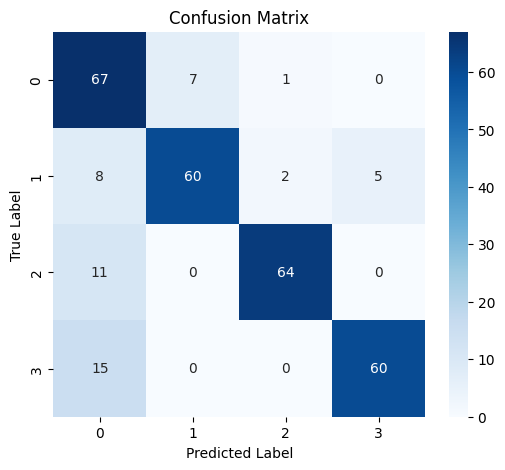

In [ ]:
plt.figure(figsize=(6, 5))
p = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(4),
    yticklabels=range(4),
)
_ = p.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")

In [13]:
roc_auc = roc_auc_score(y_test, y_probs, multi_class="ovr")
roc_auc

np.float64(0.9438074074074074)

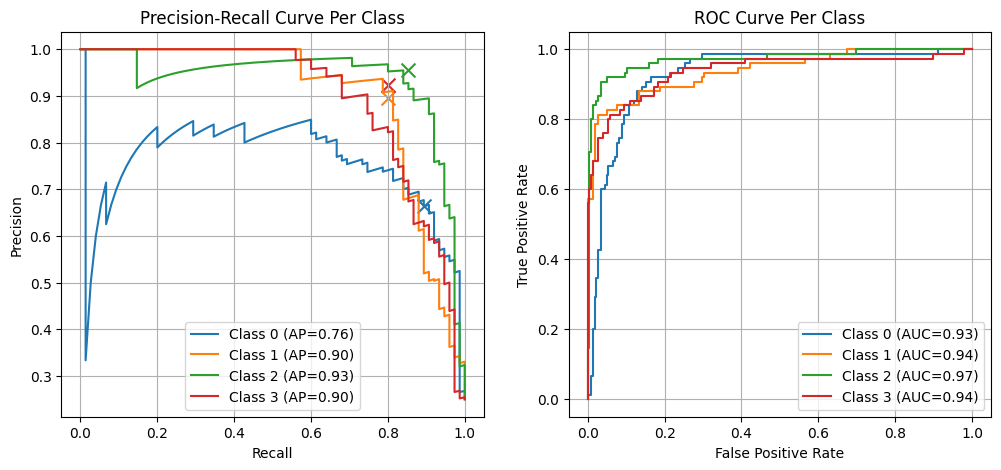

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
]

precision = {}
recall = {}
thresholds = {}
average_precision = {}
fpr = {}
tpr = {}
roc_auc = {}

# plt.figure(figsize=(10, 6))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


for class_id in range(4):
    # Convert to binary for one-vs-all
    y_true_binary = (y_test == class_id).astype(int)

    # Compute PR curve
    precision[class_id], recall[class_id], thresholds[class_id] = (
        precision_recall_curve(y_true_binary, y_probs[:, class_id])
    )

    average_precision[class_id] = average_precision_score(
        y_true_binary, y_probs[:, class_id]
    )

    # Plot PR curve
    axes[0].plot(
        recall[class_id],
        precision[class_id],
        label=f"Class {class_id} (AP={average_precision[class_id]:.2f})",
        c=colors[class_id],
    )

    axes[0].scatter(
        class_report[str(class_id)]["recall"],
        class_report[str(class_id)]["precision"],
        marker="x",
        s=100,
        c=colors[class_id],
    )

    # Compute ROC curve
    fpr[class_id], tpr[class_id], thresholds[class_id + 10] = roc_curve(
        y_true_binary, y_probs[:, class_id]
    )

    roc_auc[class_id] = roc_auc_score(y_true_binary, y_probs[:, class_id])

    # Plot ROC curve
    axes[1].plot(
        fpr[class_id],
        tpr[class_id],
        label=f"Class {class_id} (AUC={roc_auc[class_id]:.2f})",
        c=colors[class_id],
    )

    # we DON'T know The specificity for this class from the metrics.


axes[0].set_xlabel("Recall")
axes[0].set_ylabel("Precision")
axes[0].set_title("Precision-Recall Curve Per Class")
axes[0].legend()
axes[0].grid()

axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve Per Class")
axes[1].legend()
axes[1].grid()

plt.show()

- Class 2 has the highest Average Precision (0.93), indicating strong separability.
- Class 0 has the lowest Average Precision (0.76), meaning it may struggle more with precision-recall trade-offs.


In [ ]:
# Find optimal threshold per class based on F1-score maximization
optimal_thresholds = {}

for class_id in range(4):
    # Compute F1-score for different thresholds
    f1_scores = (
        2
        * (precision[class_id] * recall[class_id])
        / (precision[class_id] + recall[class_id] + 1e-10)
    )  # Avoid division by zero

    # Find the threshold that maximizes F1-score
    best_idx = np.argmax(f1_scores)
    optimal_thresholds[class_id] = (
        thresholds[class_id][best_idx] if best_idx < len(thresholds[class_id]) else 0.5
    )

optimal_thresholds

{0: np.float64(0.5184536665473387),
 1: np.float64(0.4505374572855488),
 2: np.float64(0.22163472980880614),
 3: np.float64(0.3013932146273954)}

In [49]:
# y_probs[i] is the probabilites of prediction for sample 0 to belong to each class
#
# In this loop, I check each probabilities to the new thresholds
# if they are higher, I keep the class and the probability
#
# Example:  y_probs[5] = array([0.0427148 , 0.01616562, 0.63788764, 0.30323194])
#    here, both class 2 and 3 are possbile:
#           0, -
#           1, -
#           2, 0.63788764 > 0.22163472980880614
#           3, 30323194   > 0.3013932146273954
# adjusted_preds for this will be: [(2, np.float64(0.6378876352916184)), (3, np.float64(0.30323194262384284))]

y_pred_adjusted = []

for i in range(len(y_probs)):
    adjusted_preds = [
        (c, y_probs[i, c]) for c in range(4) if y_probs[i, c] > optimal_thresholds[c]
    ]

    if not adjusted_preds:
        y_pred_adjusted.append(np.argmax(y_probs[i]))
    else:
        y_pred_adjusted.append(
            # Get the class max probability;
            # ... or could priorotize classes
            max(adjusted_preds, key=lambda x: x[1])[0]
        )


In [39]:
class_report_adjusted = classification_report(y_test, y_pred_adjusted, output_dict=True)
pd.DataFrame(class_report_adjusted).T

,precision,recall,f1-score,support
0,0.683673,0.893333,0.774566,75.000000
1,0.895522,0.800000,0.845070,75.000000
2,0.942857,0.880000,0.910345,75.000000
3,0.923077,0.800000,0.857143,75.000000
accuracy,0.843333,0.843333,0.843333,0.843333
macro avg,0.861282,0.843333,0.846781,300.000000
weighted avg,0.861282,0.843333,0.846781,300.000000


In [41]:
pd.merge(
    pd.DataFrame(class_report).T,
    pd.DataFrame(class_report_adjusted).T,
    left_index=True,
    right_index=True,
    suffixes=['', '_fixed']
)

,precision,recall,f1-score,support,precision_fixed,recall_fixed,f1-score_fixed,support_fixed
0,0.663366,0.893333,0.761364,75.000000,0.683673,0.893333,0.774566,75.000000
1,0.895522,0.800000,0.845070,75.000000,0.895522,0.800000,0.845070,75.000000
2,0.955224,0.853333,0.901408,75.000000,0.942857,0.880000,0.910345,75.000000
3,0.923077,0.800000,0.857143,75.000000,0.923077,0.800000,0.857143,75.000000
accuracy,0.836667,0.836667,0.836667,0.836667,0.843333,0.843333,0.843333,0.843333
macro avg,0.859297,0.836667,0.841246,300.000000,0.861282,0.843333,0.846781,300.000000
weighted avg,0.859297,0.836667,0.841246,300.000000,0.861282,0.843333,0.846781,300.000000


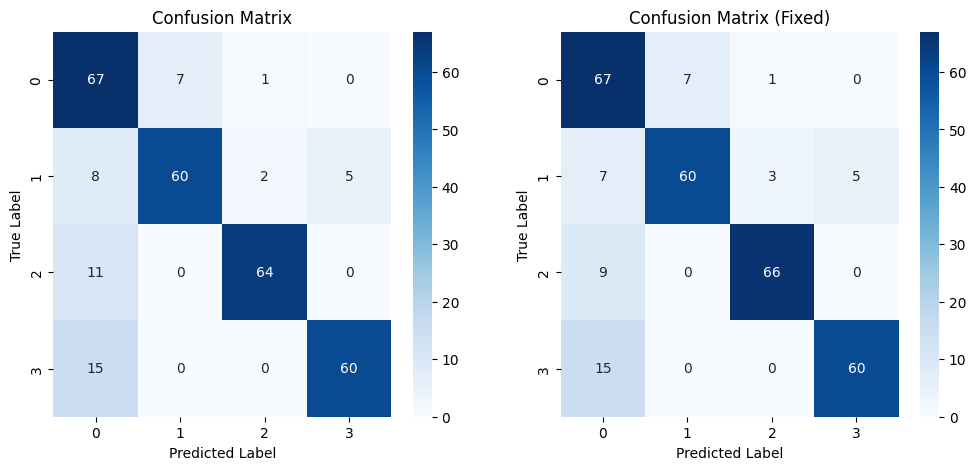

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


p = sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(4),
    yticklabels=range(4),
    ax=axes[0]
)
_ = p.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix")


p = sns.heatmap(
    confusion_matrix(y_test, y_pred_adjusted),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(4),
    yticklabels=range(4),
    ax=axes[1]
)
_ = p.set(xlabel="Predicted Label", ylabel="True Label", title="Confusion Matrix (Fixed)")